**Resnet 50 with Fastai**

Open the dataset and import the images with his respective class.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import glob

from fastai.vision.all import *
set_seed(42)

#/kaggle/input/paddy-doctor-diseases-small-400-split


# train images
train_path = '/content/drive/MyDrive/paddy-doctor-diseases-small-split/train'
train_files = get_image_files(train_path)

# test images
test_path = '/content/drive/MyDrive/paddy-doctor-diseases-small-split/test'
test_files = get_image_files(test_path).sorted()

# train labels
train_df = pd.read_csv('/content/drive/MyDrive/paddy-doctor-diseases-small-split/metadata-train.csv')
print(train_df.shape)
train_df.label.value_counts()

(12980, 4)


normal                      1924
blast                       1881
hispa                       1720
tungro                      1561
white_stem_borer            1019
brown_spot                  1004
leaf_roller                  876
downy_mildew                 694
yellow_stem_borer            613
bacterial_leaf_blight        518
bacterial_leaf_streak        405
black_stem_borer             405
bacterial_panicle_blight     360
Name: label, dtype: int64

#### Dataloaders for fastai training

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(train_path)

In [ ]:
dls = ImageDataLoaders.from_folder(
    train_path, 
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

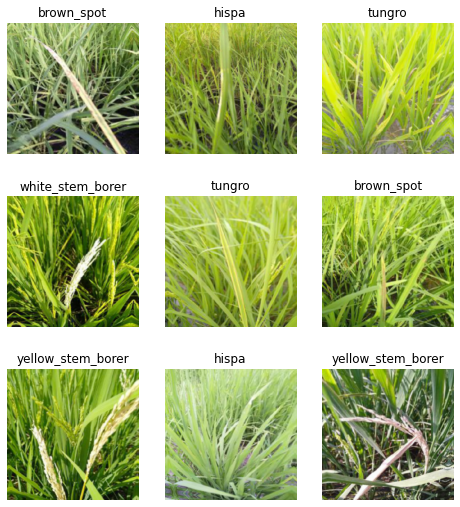

In [ ]:
dls.show_batch(figsize=(8,9))

### Setlup a learner based on resnet50


In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Fine-tune the resnet50 model



In [ ]:
%%timeit
learn.fine_tune(10, 0.005)

epoch,train_loss,valid_loss,error_rate,time
0,0.015632,0.124676,0.022727,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.019224,0.121748,0.022727,00:29
1,0.034432,0.144487,0.029276,00:29
2,0.060860,0.175999,0.031587,00:29
3,0.065690,0.183775,0.039291,00:29
4,0.055566,0.139796,0.031972,00:30
5,0.033294,0.122711,0.028891,00:29
6,0.023168,0.138334,0.027350,00:29
7,0.019718,0.120461,0.025809,00:29
8,0.013991,0.113482,0.025039,00:29
9,0.010495,0.117481,0.024653,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.018345,0.130977,0.028120,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.017921,0.145374,0.028891,00:29
1,0.032986,0.208466,0.036980,00:29
2,0.070568,0.178214,0.036980,00:29
3,0.058636,0.152859,0.031587,00:29
4,0.040819,0.164968,0.034284,00:29
5,0.026914,0.143709,0.030431,00:29
6,0.022959,0.122451,0.027350,00:29
7,0.020906,0.120965,0.024268,00:29
8,0.013149,0.113865,0.024653,00:29
9,0.011413,0.114128,0.023112,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.012813,0.136189,0.025809,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.018199,0.134660,0.025039,00:29
1,0.034444,0.194302,0.031587,00:29
2,0.059200,0.188563,0.039676,00:28
3,0.050592,0.160855,0.036595,00:29
4,0.032905,0.136422,0.031972,00:29
5,0.027743,0.173745,0.030431,00:29
6,0.024241,0.136930,0.029276,00:29
7,0.015093,0.134194,0.025039,00:29
8,0.010561,0.132185,0.024268,00:29
9,0.009612,0.137069,0.024268,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.014153,0.160523,0.026579,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.016511,0.162692,0.026579,00:29
1,0.028185,0.173993,0.031202,00:29
2,0.042356,0.181274,0.035824,00:29
3,0.063207,0.183895,0.036980,00:29
4,0.039877,0.131460,0.027735,00:29
5,0.030571,0.141041,0.024653,00:29
6,0.018248,0.127654,0.026579,00:29
7,0.013122,0.116990,0.024653,00:29
8,0.011986,0.118640,0.023883,00:29
9,0.009783,0.117483,0.022727,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.014997,0.143274,0.025809,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.013305,0.137588,0.021957,00:29
1,0.032230,0.144561,0.028505,00:29
2,0.035214,0.152284,0.028891,00:29
3,0.030565,0.222587,0.032743,00:29
4,0.043674,0.150638,0.030046,00:29
5,0.027036,0.158533,0.030431,00:29
6,0.021450,0.131014,0.022342,00:29
7,0.014387,0.133113,0.024268,00:29
8,0.009482,0.121371,0.024268,00:29
9,0.006744,0.121125,0.022727,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.012365,0.125224,0.025039,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.010874,0.147632,0.026965,00:29
1,0.025533,0.167544,0.030817,00:29
2,0.043671,0.167254,0.031587,00:29
3,0.042117,0.146940,0.029661,00:29
4,0.032362,0.176313,0.033513,00:29
5,0.022666,0.190143,0.032743,00:29
6,0.018822,0.142390,0.028120,00:28
7,0.014413,0.136761,0.025809,00:29
8,0.010287,0.141201,0.028120,00:29
9,0.008129,0.138970,0.028505,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.011099,0.151709,0.029276,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.012881,0.158367,0.027350,00:29
1,0.026459,0.172640,0.030431,00:29
2,0.053412,0.211626,0.036210,00:29
3,0.041604,0.154007,0.031587,00:29
4,0.036807,0.149957,0.029276,00:29
5,0.021220,0.151744,0.028505,00:29
6,0.015486,0.141845,0.027735,00:29
7,0.013498,0.148141,0.025039,00:29
8,0.008022,0.134777,0.025809,00:29
9,0.007307,0.141857,0.025039,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.008418,0.163025,0.025809,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.010985,0.154408,0.023883,00:29
1,0.038643,0.183688,0.031202,00:29
2,0.035727,0.164278,0.035054,00:29
3,0.032506,0.166485,0.031587,00:29
4,0.034498,0.161790,0.032743,00:29
5,0.021974,0.157975,0.029661,00:29
6,0.013144,0.165350,0.029276,00:29
7,0.013006,0.136868,0.027735,00:29
8,0.008436,0.135771,0.025424,00:29
9,0.004230,0.133994,0.024653,00:28


5min 20s ± 805 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Model predictions

In [ ]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0247)

In [ ]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0235)

Uses images for the test of our model


In [ ]:
# test images
test_path ='/content/drive/MyDrive/paddy-doctor-diseases-small-split/test'
test_files = get_image_files(test_path).sorted()
test_classes = [f.parent.name for f in test_files]
probs, _ = learn.tta(dl=dls.test_dl(test_files))
preds = probs.argmax(dim=1)
pred_classes = dls.vocab[preds]

### Results

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

cls_report = classification_report(test_classes, pred_classes, 
                                   digits=5)
print(cls_report)
acc = accuracy_score(test_classes, pred_classes)


                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.99219   0.97692   0.98450       130
   bacterial_leaf_streak    0.98980   0.97000   0.97980       100
bacterial_panicle_blight    1.00000   0.98889   0.99441        90
        black_stem_borer    0.98020   0.98020   0.98020       101
                   blast    0.98298   0.98298   0.98298       470
              brown_spot    0.98419   0.98419   0.98419       253
            downy_mildew    0.93889   0.97126   0.95480       174
                   hispa    0.97685   0.97912   0.97798       431
             leaf_roller    0.97297   0.98630   0.97959       219
                  normal    0.98952   0.98129   0.98539       481
                  tungro    0.99227   0.98718   0.98972       390
        white_stem_borer    0.98054   0.99213   0.98630       254
       yellow_stem_borer    0.99333   0.98026   0.98675       152

                accuracy                        0.98243      3245
        

In [ ]:
print(acc)

0.9824345146379044


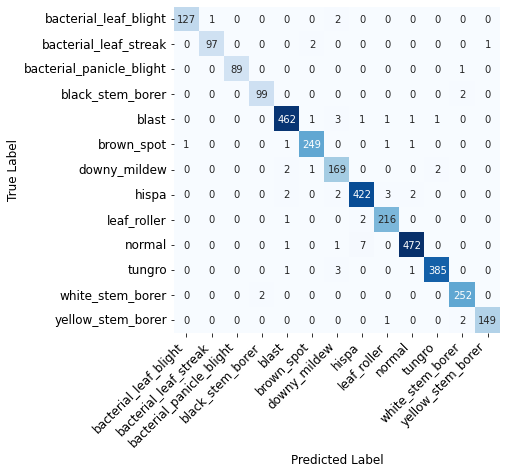

[[127   1   0   0   0   0   2   0   0   0   0   0   0]
 [  0  97   0   0   0   2   0   0   0   0   0   0   1]
 [  0   0  89   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0  99   0   0   0   0   0   0   0   2   0]
 [  0   0   0   0 462   1   3   1   1   1   1   0   0]
 [  1   0   0   0   1 249   0   0   1   1   0   0   0]
 [  0   0   0   0   2   1 169   0   0   0   2   0   0]
 [  0   0   0   0   2   0   2 422   3   2   0   0   0]
 [  0   0   0   0   1   0   0   2 216   0   0   0   0]
 [  0   0   0   0   1   0   1   7   0 472   0   0   0]
 [  0   0   0   0   1   0   3   0   0   1 385   0   0]
 [  0   0   0   2   0   0   0   0   0   0   0 252   0]
 [  0   0   0   0   0   0   0   0   1   0   0   2 149]]


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

class_names = dls.vocab
plot_heatmap(test_classes, pred_classes, class_names, ax, title="Resnet50")   


plt.show()
cm = confusion_matrix(test_classes, pred_classes)
print(cm)

In [ ]:
plt.show(test_classes, pred_classes)


In [ ]:
res = pd.DataFrame({"y_true":test_classes,
                      "y_pred":pred_classes})
res.to_csv('result.csv', index=False)
res

,y_true,y_pred
0,bacterial_leaf_blight,bacterial_leaf_blight
1,bacterial_leaf_blight,bacterial_leaf_blight
2,bacterial_leaf_blight,bacterial_leaf_blight
3,bacterial_leaf_blight,bacterial_leaf_blight
4,bacterial_leaf_blight,bacterial_leaf_blight
...,...,...
3240,yellow_stem_borer,yellow_stem_borer
3241,yellow_stem_borer,yellow_stem_borer
3242,yellow_stem_borer,yellow_stem_borer
3243,yellow_stem_borer,yellow_stem_borer


In [ ]:
#run inference on test images
import glob
from IPython.display import Image, display
model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/drive/MyDrive/paddy-doctor-diseases-small-split/test/*/*.jpg'):
    prediction = learn.predict(imageName)
    print("prediction:",prediction[0])
    print("real:",imageName)
    display(Image(filename=imageName))
    print("\n")